In [1]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00


In [19]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.0 MB/s eta 0:00:00


In [24]:
import os
import json
import datetime
import time
import pandas as pd

In [3]:
# Set up a DataFrame to store results
results = pd.DataFrame(columns=["model", "prompt", "suggestion", "response_time"])

In [78]:
# Load API keys from config.json
with open("config.json") as f:
    config = json.load(f)

In [16]:
# Function to read prompts from the folder
def load_prompts(directory="prompts"):
  prompts = []
  for filename in os.listdir(directory):
    if filename.endswith(".txt"):
      with open(os.path.join(directory, filename), "r") as file:
        prompts.append(file.read())
  return prompts

In [75]:
from groq import Groq

def call_groc_model(model_name, prompt):
  """ Call a Groq model API """
  client = Groq(
      api_key = config['groq']['api_key']
  )

  return client.chat.completions.create(
      model=model_name,
      messages=[
          {
              "role": "user",
              "content": "Analyse the code, fix any issues with it and propose solutions to avois boilerplate code by implementing reusable code if possible, return only the code:" + prompt
          }
      ],
      temperature=1,
      max_tokens=1024,
      top_p=1,
      stream=False,
      stop=None,
  )

In [23]:
import ast

def evaluate_reusability(code_snippet):
    """
    Evaluates the reusability of a code snippet based on modularity, parameterization,
    minimal dependencies, and use of abstraction.
    """
    # Parse code into an Abstract Syntax Tree (AST)
    tree = ast.parse(code_snippet)

    # Initialize metrics for reusability
    num_functions = 0
    parameterized_functions = 0
    modularity_score = 0

    for node in ast.walk(tree):
        # Check for functions and their parameters (modularity and parameterization)
        if isinstance(node, ast.FunctionDef):
            num_functions += 1
            if node.args.args:  # If the function has parameters
                parameterized_functions += 1
            if any(isinstance(n, ast.Return) for n in node.body):
                modularity_score += 1  # Increment modularity for return statements

    # Simple scoring mechanism
    if num_functions == 0:
        return {"reusability_score": 0, "feedback": "Code lacks functions, making it less reusable."}

    param_ratio = parameterized_functions / num_functions
    modularity_ratio = modularity_score / num_functions

    reusability_score = (param_ratio + modularity_ratio) / 2 * 100
    feedback = "Higher parameterization and modularity increase reusability."

    return {"reusability_score": reusability_score, "feedback": feedback}

In [51]:
# DF for metrics
df_metrics = pd.DataFrame(columns=[
    "api_name", "model_name", "latency", "tokens_used",
    "readability_score"
])

In [73]:
import textstat

def benchmark_model(api_name, model_name, prompt, api_type):
  """ Benchmark a certain model """

  # Start time for latency
  start_time = time.time()

  # Call model API
  match api_type:
    case "groq":
      response = call_groc_model(model_name, prompt)
    case _:
      print(api_type, "is not an available API type")
      return

  # End timer
  end_time = time.time()
  latency = end_time - start_time

  # Gather metrics
  tokens_used = response.usage.total_tokens
  generated_text = response.choices[0].message.content

  # Calculate quality metrics (pseudo-code for readability and reusability checks)
  readability_score = textstat.flesch_kincaid_grade(generated_text)
  # reusability_score = evaluate_reusability(generated_text)

  # Append to DataFrame directly
  df_metrics.loc[len(df_metrics)] = {
    "api_name": api_name,
    "model_name": model_name,
    "latency": latency,
    "tokens_used": tokens_used,
    "readability_score": readability_score,
    # "reusability_score": reusability_score
  }

  timestamp = datetime.datetime.now().strftime("%d%m%Y%H%M%S")
  output_file_name = f"{model_name}_code_{timestamp}.txt"

  with open(output_file_name, 'w') as output_file:
    output_file.write(response.choices[0].message.content)

In [79]:
# Example usage
prompts = load_prompts()

# benchmark_model("llama", "llama3-8b-8192", prompts[1], "groq")
benchmark_model("gemma2", "gemma2-9b-it", prompts[1], "groq")

print(df_metrics)

  api_name      model_name   latency  tokens_used  readability_score
0    llama  llama3-8b-8192  0.719124          873                9.1
1   gemma2    gemma2-9b-it  1.073767          844               15.0


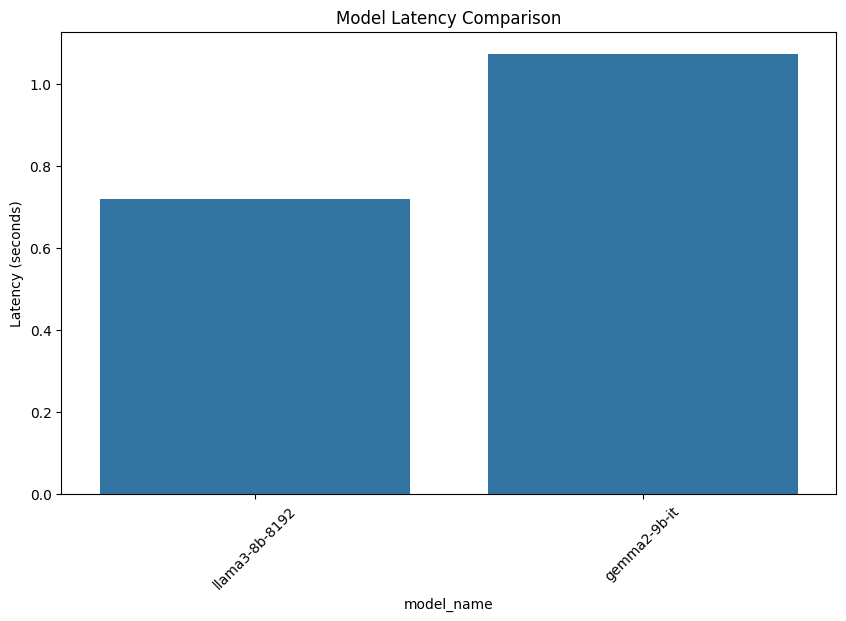

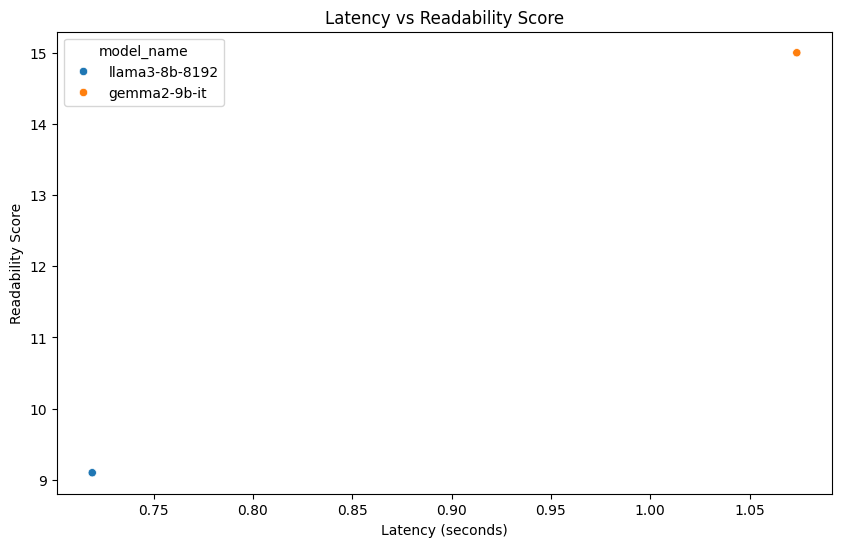

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot of latency
plt.figure(figsize=(10, 6))
sns.barplot(x='model_name', y='latency', data=df_metrics)
plt.title('Model Latency Comparison')
plt.ylabel('Latency (seconds)')
plt.xticks(rotation=45)
plt.show()

# Scatterplot of latency vs readability
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latency', y='readability_score', hue='model_name', data=df_metrics)
plt.title('Latency vs Readability Score')
plt.xlabel('Latency (seconds)')
plt.ylabel('Readability Score')
plt.show()